In [1]:
%load_ext autoreload
%autoreload 2
import os
os.chdir('/home/jorge/thesis')

from pytorch3d.io import load_objs_as_meshes
import torch
from pytorch3d.renderer import FoVPerspectiveCameras
from text3d2video.util import read_obj_uvs
from text3d2video.utilities.mesh_processing import normalize_meshes

torch.set_grad_enabled(False)

# read mesh
mesh_path = "data/meshes/cat_statue.obj"

device = "cuda"
mesh = load_objs_as_meshes([mesh_path], device=device)
mesh = normalize_meshes(mesh)
verts_uvs, faces_uvs = read_obj_uvs(mesh_path)

/home/jorge/miniconda3/envs/thesis4/lib/python3.9/site-packages/pytorch3d/io/obj_io.py:550: UserWarning: Mtl file does not exist: data/meshes/cat_statue.mtl
  warnings.warn(f"Mtl file does not exist: {f}")


# Setup Image & initial texture

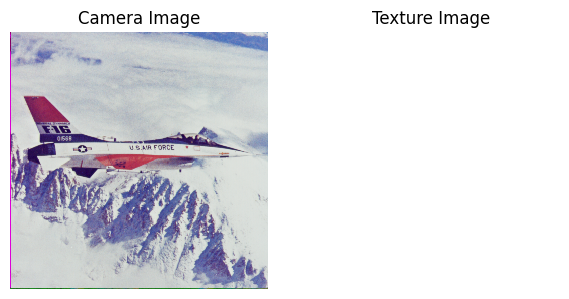

In [2]:
from matplotlib import pyplot as plt
import torch
from torchvision.io import read_image
import torchvision.transforms.functional as TF

from text3d2video.utilities.ipython_utils import display_ims

TEXTURE_RES = 512
CAMERA_RES = 512
texture_image = torch.ones(TEXTURE_RES, TEXTURE_RES, 3).to(device).float()

camera_image = read_image("data/images/airplane.png") / 255
camera_image = TF.resize(camera_image, (CAMERA_RES, CAMERA_RES)).cuda()

# Plot the images
texture_im = texture_image.cpu()
camera_image_im = TF.to_pil_image(camera_image.cpu())
display_ims(
    [camera_image_im, texture_im], titles=["Camera Image", "Texture Image"], scale=3
)

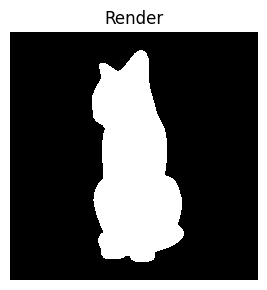

In [3]:
from text3d2video.rendering import render_texture
from text3d2video.utilities.camera_placement import turntable_extrinsics

R, T = turntable_extrinsics(angles=20, dists=2)
cam = FoVPerspectiveCameras(R=R, T=T, device=device, fov=40)
renders = render_texture(mesh, cam, texture_image, verts_uvs, faces_uvs)[0].cpu()

display_ims([TF.to_pil_image(renders)], titles=["Render"])

In [4]:
from text3d2video.backprojection import compute_texel_projection

projection = compute_texel_projection(
    mesh, cam, verts_uvs, faces_uvs, raster_res=512, texture_res=TEXTURE_RES
)
torch.cuda.empty_cache()

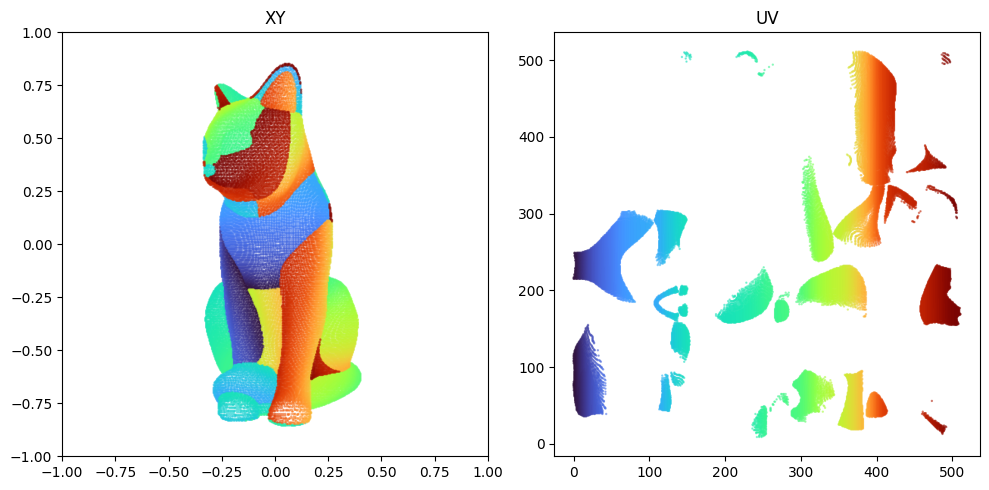

In [5]:
from matplotlib.axes import Axes
from text3d2video.backprojection import TexelProjection


def plot_projection(
    texel_projection: TexelProjection,
    ax_xy: Axes,
    ax_uv: Axes,
    xy_image = None,
    uv_image = None,
    cmap="turbo",
    s=0.5,
    alpha=0.5,
):
    indices = torch.arange(0, texel_projection.xys.shape[0], device=device)

    if xy_image is not None:
        ax_xy.imshow(xy_image, extent=(-1, 1, -1, 1))

    ax_xy.set_xlim(-1, 1)
    ax_xy.set_ylim(-1, 1)
    ax_xy.set_title("XY")

    ax_xy.scatter(
        texel_projection.xys[:, 0].cpu(),
        texel_projection.xys[:, 1].cpu(),
        s=s,
        c=indices.cpu(),
        cmap=cmap,
        alpha=alpha,
    )

    if uv_image is not None:
        ax_uv.imshow(uv_image)

    ax_uv.scatter(
        texel_projection.uvs[:, 0].cpu(),
        texel_projection.uvs[:, 1].cpu(),
        s=s,
        c=indices.cpu(),
        cmap=cmap,
        alpha=alpha,
    )
    ax_uv.set_title("UV")

    plt.tight_layout()

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
ax_xy = axs[0]
ax_uv = axs[1]
plot_projection(projection, ax_xy, ax_uv)

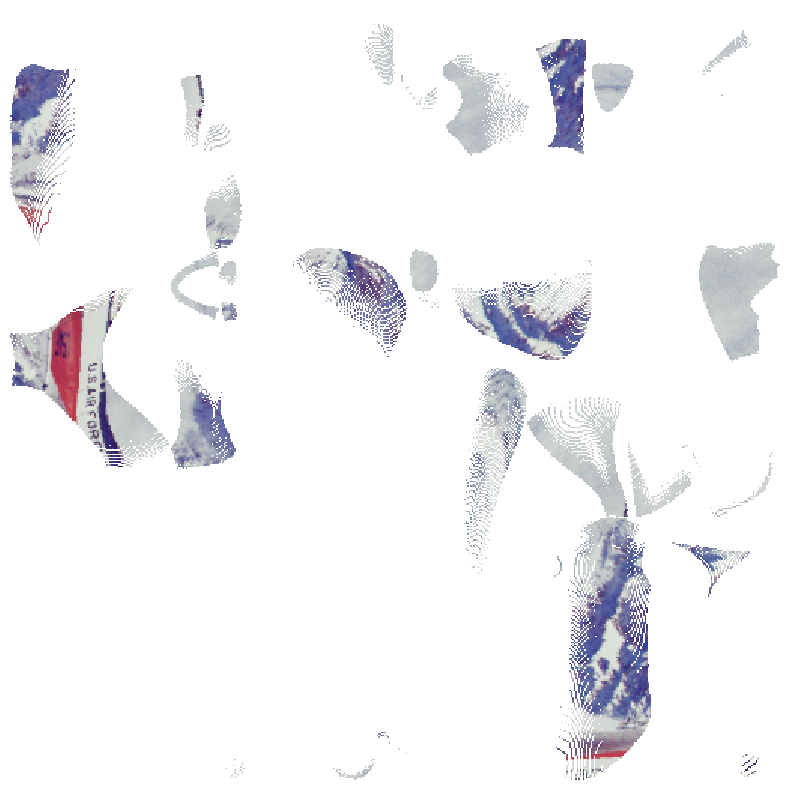

In [6]:
from text3d2video.util import sample_feature_map_ndc
from text3d2video.utilities.ipython_utils import display_ims

xy_coords_ndc = projection.xys.clone()

colors = sample_feature_map_ndc(camera_image, xy_coords_ndc)

updated_texture = texture_image.clone()
updated_texture[projection.uvs[:, 1], projection.uvs[:, 0]] = colors

display_ims([updated_texture.cpu()], scale=8)

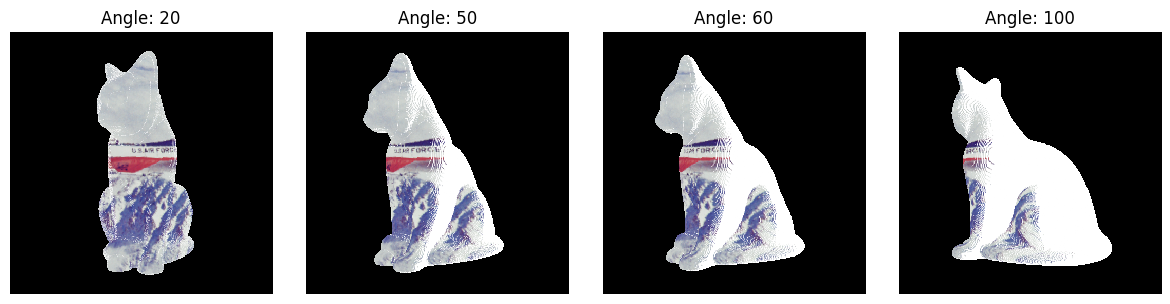

In [7]:
from text3d2video.rendering import (
    render_texture,
)
from text3d2video.utilities.camera_placement import turntable_extrinsics

angles = [20, 50, 60, 100]
R, T = turntable_extrinsics(angles=angles, dists=2)
cams = FoVPerspectiveCameras(R=R, T=T, device=device, fov=40)

render_meshes = mesh.extend(len(angles))
renders = render_texture(render_meshes, cams, updated_texture, verts_uvs, faces_uvs).cpu()

renders_pil = [TF.to_pil_image(r) for r in renders]
display_ims(renders_pil, titles=[f"Angle: {angle}" for angle in angles], scale=3)